# **House Price Prediction with Regression**

## Objectives

* Fit ML regression model for prediction of sale price of inherited houses and any other house in the region

## Inputs

* Cleaned dataset
* outputs/datasets/cleaned/HousePricesCleaned.csv
* Variables determined in the data cleaning and feature engineering notebook

## Outputs

* ML pipeline for house price prediction 

## Conclusions

* 

---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
import os
current_dir = os.getcwd()
current_dir

'c:\\My_Folders\\CodeInstitute\\Project_5_files\\Project-5\\Project-5\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'c:\\My_Folders\\CodeInstitute\\Project_5_files\\Project-5\\Project-5'

# Load the data

Section 1 content

In [5]:
import numpy as np
import pandas as pd
df = pd.read_csv("outputs/datasets/collection/house_prices.csv") 

print(df.shape)
df.head(3)

(1460, 24)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500


---

# ML Pipeline: Regression
## Libraries for ML pipeline must be imported

In [6]:
from sklearn.pipeline import Pipeline

### Data Cleaning Step
from feature_engine.imputation import MeanMedianImputer
from feature_engine.selection import DropFeatures
from feature_engine.imputation import CategoricalImputer

### Feature Engineering Step
from feature_engine import creation
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer

### Feature Scaling Step
from sklearn.preprocessing import StandardScaler

### Feature Selection Step
from sklearn.feature_selection import SelectFromModel

### ML algorithms to be applied
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

## Create the ML pipeline

- The pipeline steps for data cleaning and feature engineering combined in PipelineOptimization
- This step applies the defined preprocessing of data before a ML model is applied
- The features included in drop/mean/median etc are those determined in the previous notebook steps

Section 2 content

In [7]:
# Pipeline optimization
def PipelineOptimization(model):
  pipeline_base = Pipeline([
    # Data cleaning (copied from Data Cleaning notebook)
     ( 'drop',  DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF', 'GarageFinish', 'BsmtFinType1', 'BsmtExposure'])),

     ( 'mean',  MeanMedianImputer(imputation_method='mean',
                                     variables=['LotFrontage', 'BedroomAbvGr']) ),

     ( 'median',  MeanMedianImputer(imputation_method='median',
                                     variables=['2ndFlrSF', 'GarageYrBlt', 'MasVnrArea']) ),
   
    # ( 'categorical',  CategoricalImputer(imputation_method='missing',
    #                                  fill_value='Unf',
    #                                  variables=[]) ),

    # Feature engineering (copied from Feature Engineering notebook)
    ("OrdinalCategoricalEncoder",OrdinalEncoder(encoding_method='arbitrary', 
                                                  variables = ['KitchenQual'])),
    
    ('lt', vt.LogTransformer(variables = ['GrLivArea', 'LotArea', 'LotFrontage']) ),

    ('pt', vt.PowerTransformer(variables = ['GarageArea', 'MasVnrArea', 'OpenPorchSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF']) ),
       
      
    ("Winsoriser_iqr",Winsorizer(capping_method='iqr', fold=1.5, tail='both', 
                                                  variables=['1stFlrSF',
                                                             '2ndFlrSF',
                                                             'GarageArea',
                                                             'LotArea',
                                                             'LotFrontage',
                                                             'MasVnrArea',
                                                             'OpenPorchSF',
                                                             'TotalBsmtSF',
                                                      ])),      
       
    ("SmartCorrelatedSelection",SmartCorrelatedSelection(variables= None,
       method="spearman", threshold=0.8,selection_method="variance") ),

    ("feat_scaling", StandardScaler() ),

    ("feat_selection",  SelectFromModel(model) ),

    ("model", model ),
    ])

  return pipeline_base

Custom Class for hyperparameter optimisation

- code copied from walkthrough project of Code Institute

In [8]:
from sklearn.model_selection import GridSearchCV
class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model=  PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

# Split Train and Test Set

---

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(
                                    df.drop(['SalePrice'], axis=1) ,
                                    df['SalePrice'],
                                    test_size=0.2,
                                    random_state=0
                                    )

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 23) (1168,) 
* Test set: (292, 23) (292,)


# Grid Search Cross-Validation - Sklearn

- Search for the best hyperparameter for ML model with cross-validation, i.e. the data is split into subsets. The model is trained on one of those subsets and tested against the remainder of the subsets not used as train subset

## Step 1 in hyperparameter optimisation | default hyperparameters to determine best algorithm

- In the first step, the best model is determined based on default hyperparameters

In [10]:
models_quick_search = {
    "LinearRegression": LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

# Code taken from Scikit-learn videos/instructions
params_quick_search = {
    "LinearRegression": {},

    "DecisionTreeRegressor": {'model__max_depth': [None,4, 15],
                             'model__min_samples_split': [2,50],
                             'model__min_samples_leaf': [1,50],
                             'model__max_leaf_nodes': [None,50],
        },

    "RandomForestRegressor": {'model__n_estimators': [100,50, 140],
                             'model__max_depth': [None,4, 15],
                             'model__min_samples_split': [2,50],
                             'model__min_samples_leaf': [1,50],
                             'model__max_leaf_nodes': [None,50],
        },

    "ExtraTreesRegressor": {'model__n_estimators': [100,50,150],
        'model__max_depth': [None, 3, 15],
        'model__min_samples_split': [2, 50],
        'model__min_samples_leaf': [1,50],
        },

    "AdaBoostRegressor": {'model__n_estimators': [50,25,80,150],
                          'model__learning_rate':[1,0.1, 2],
                          'model__loss':['linear', 'square', 'exponential'],
        },

    "GradientBoostingRegressor": {'model__n_estimators': [100,50,140],
                                  'model__learning_rate':[0.1, 0.01, 0.001],
                                  'model__max_depth': [3,15, None],
                                  'model__min_samples_split': [2,50],
                                  'model__min_samples_leaf': [1,50],
                                  'model__max_leaf_nodes': [None,50],
        },

    "XGBRegressor": {'model__n_estimators': [30,80,200],
                    'model__max_depth': [None, 3, 15],
                    'model__learning_rate': [0.01,0.1,0.001],
                    'model__gamma': [0, 0.1],
        },
}

- determine best hyperparameters for each model selected (the model from model_quick_search). Hyperparameters that are tested are taken from params_quick_search
- Models selected are trained on X_train and y_train with a five-foled cross-validation (cv)
- Model performance is determined with R2

NOTE

In [11]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 24 candidates, totalling 120 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 72 candidates, totalling 360 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


c:\Users\wstab\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 54 candidates, totalling 270 fits


Check of results

In [12]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators,model__learning_rate,model__loss,model__gamma
124,ExtraTreesRegressor,0.766093,0.815705,0.853566,0.040349,15,NaN,1,50,100,NaN,NaN,NaN
100,ExtraTreesRegressor,0.765955,0.815677,0.853566,0.040383,None,NaN,1,50,100,NaN,NaN,NaN
126,ExtraTreesRegressor,0.76353,0.815268,0.85295,0.039944,15,NaN,1,50,150,NaN,NaN,NaN
102,ExtraTreesRegressor,0.763435,0.815241,0.85295,0.039962,None,NaN,1,50,150,NaN,NaN,NaN
101,ExtraTreesRegressor,0.761919,0.814121,0.854474,0.04095,None,NaN,1,50,50,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,XGBRegressor,0.006779,0.03129,0.042061,0.012821,None,NaN,NaN,NaN,30,0.001,NaN,0
430,XGBRegressor,0.006779,0.03129,0.042061,0.012821,None,NaN,NaN,NaN,30,0.001,NaN,0.1
433,XGBRegressor,0.006251,0.030419,0.041866,0.012666,3,NaN,NaN,NaN,30,0.001,NaN,0.1
406,XGBRegressor,0.006251,0.030419,0.041866,0.012666,3,NaN,NaN,NaN,30,0.001,NaN,0


---

## Search on best model to determine best hyperparameter configuration

Model definition and parameter definition for ExtensiveSearch

In [13]:
models_search = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
}

params_search = {
    "ExtraTreesRegressor":{'model__n_estimators': [50,100,150],
        'model__max_depth': [None, 3, 15],
        'model__min_samples_split': [2, 50],
        'model__min_samples_leaf': [1,50],
        },
}

Extensive GridSearch CV

In [14]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


# Push files to Repo

In [15]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators
28,ExtraTreesRegressor,0.766093,0.815705,0.853566,0.040349,15,1,50,100
4,ExtraTreesRegressor,0.765955,0.815677,0.853566,0.040383,None,1,50,100
29,ExtraTreesRegressor,0.76353,0.815268,0.85295,0.039944,15,1,50,150
5,ExtraTreesRegressor,0.763435,0.815241,0.85295,0.039962,None,1,50,150
3,ExtraTreesRegressor,0.761919,0.814121,0.854474,0.04095,None,1,50,50
27,ExtraTreesRegressor,0.761687,0.814075,0.854474,0.04101,15,1,50,50
26,ExtraTreesRegressor,0.682884,0.809271,0.870693,0.068807,15,1,2,150
25,ExtraTreesRegressor,0.678529,0.807174,0.870031,0.06987,15,1,2,100
2,ExtraTreesRegressor,0.669894,0.806349,0.870304,0.073527,None,1,2,150
1,ExtraTreesRegressor,0.667553,0.804852,0.869188,0.074585,None,1,2,100


Check of best model

In [16]:
best_model = grid_search_summary.iloc[0,0]
best_model

'ExtraTreesRegressor'

Extract the best hyperparameter for the best model from the grid search results

In [17]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__max_depth': 15,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 50,
 'model__n_estimators': 100}

* 

Definition of best regressor from search

In [18]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('drop',
                 DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF',
                                                'GarageFinish', 'BsmtFinType1',
                                                'BsmtExposure'])),
                ('mean',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['LotFrontage', 'BedroomAbvGr'])),
                ('median',
                 MeanMedianImputer(variables=['2ndFlrSF', 'GarageYrBlt',
                                              'MasVnrArea'])),
                ('OrdinalCategoricalEncoder',
                 OrdinalEncoder(...
                                       'LotArea', 'LotFrontage', 'MasVnrArea',
                                       'OpenPorchSF', 'TotalBsmtSF'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance')),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=ExtraTreesRegressor(random_state=0))),
                ('model',
                 ExtraTreesRegressor(max_depth=15, min_samples_split=50,
                                     random_state=0))])

## Assessment of feature importance

Identify the most important features that are used by the best regression model. Visualize important features.

* Here are the 5 most important features in order. The model was trained on them: 
['OverallQual', 'GrLivArea', 'GarageArea', 'YearBuilt', 'TotalBsmtSF']


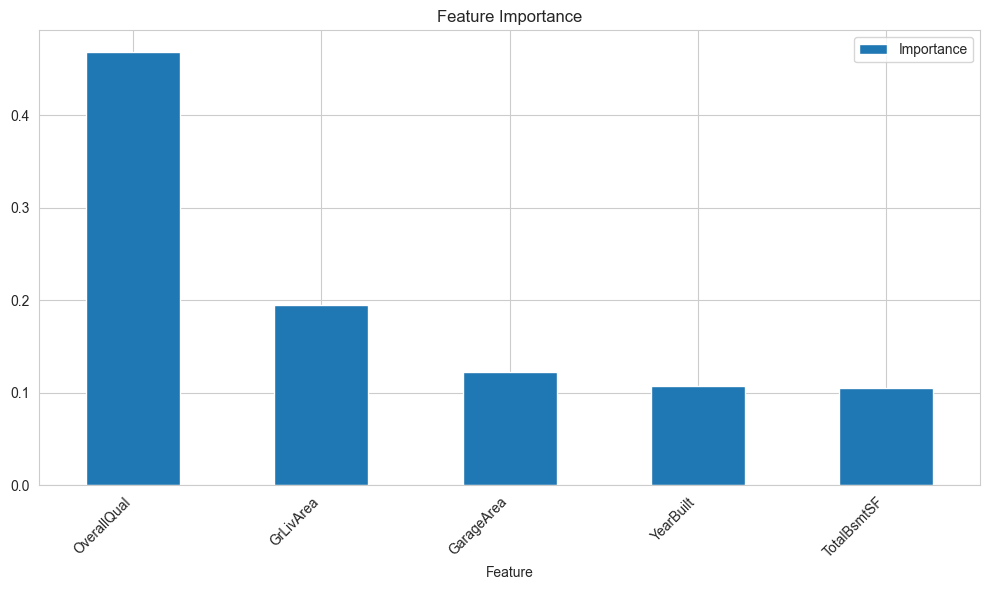

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_style('whitegrid')

# Define the number of steps for data cleaning and feature engineering
data_cleaning_feat_eng_steps = 9

# Apply the steps to the training data
temp_pipeline = Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
transformed_data = temp_pipeline.fit_transform(X_train)

# Extract the actual feature name
try:
    
    columns_after_data_cleaning_feat_eng = temp_pipeline.get_feature_names_out()
except AttributeError:
      columns_after_data_cleaning_feat_eng = [f"Feature_{i}" for i in range(transformed_data.shape[1])]

# Selection of the best features
feat_support = best_regressor_pipeline['feat_selection'].get_support()
best_features = [columns_after_data_cleaning_feat_eng[i] for i, is_selected in enumerate(feat_support) if is_selected]

# Create a DataFrame to show the importance of features
df_feature_importance = pd.DataFrame({
    'Feature': best_features,
    'Importance': best_regressor_pipeline['model'].feature_importances_,
}).sort_values(by='Importance', ascending=False)

# Statement for most important features and visualization with a plot
print(f"* Here are the {len(best_features)} most important features in order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance', figsize=(10, 6))
plt.xticks(rotation=45, ha='right')
plt.title("Feature Importance")
plt.tight_layout()
plt.show()
